<a href="https://colab.research.google.com/github/felixzhao/HARDataset/blob/main/Halter_V2_HAR_non_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
# import itertools

from sklearn.metrics import confusion_matrix
from datetime import datetime
from sklearn.metrics import accuracy_score


from sklearn import metrics

from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
prefix_path = "drive/MyDrive/UCI_HAR_Dataset"

## train data

In [7]:
class HARFeatureLoader:
    def __init__(self, root_path):
        self.root = root_path
        features_path = f'{prefix_path}/features.txt'
        self.x_train_path = f'{prefix_path}/train/X_train.txt'
        self.subject_train_path = f'{prefix_path}/train/subject_train.txt'
        self.label_dict = {
            1: 'WALKING', 
            2:'WALKING_UPSTAIRS',
            3:'WALKING_DOWNSTAIRS',
            4:'SITTING', 
            5:'STANDING',
            6:'LAYING'
            }
        self.feature_names = self._load_features_names(features_path)
        self.train_df = None
        self.test_df = None

    def _load_features_names(self, path:str):
        feature_names = []
        with open(path) as f:
            feature_names = [line.split()[1] for line in f.readlines()]
        return feature_names

    def _generate_path(self, split_type:str):
        x_path = f'{prefix_path}/{split_type}/X_{split_type}.txt'
        subject_path = f'{prefix_path}/{split_type}/subject_{split_type}.txt'
        y_path = f'{prefix_path}/{split_type}/y_{split_type}.txt'
        return x_path, subject_path, y_path

    def _remove_duplicate_columns(self, df):
        df_copy = df.copy()

        # find duplicate column names
        duplicate_cols = df_copy.columns.duplicated()

        # drop duplicate columns
        return df_copy.drop(df_copy.columns[duplicate_cols], axis=1)

    def _load(self, x_path, subject_path, y_path):
        x = pd.read_csv(x_path, delim_whitespace=True, header=None)
        x.columns = [self.feature_names]
        x['subject'] = pd.read_csv(subject_path, header=None, squeeze=True)
        y = pd.read_csv(y_path, names=['Activity'], squeeze=True)
        y_labels = y.map(self.label_dict)
        df = x
        df['Activity'] = y
        df['ActivityName'] = y_labels
        return df

    def _load_features(self, df):
        raw_df = self._remove_duplicate_columns(df)
        columns = raw_df.columns \
                        .get_level_values(0) \
                        .str.replace('[()]','') \
                        .str.replace('[-]', '') \
                        .str.replace('[,]','')
        raw_df.columns = columns
        x = raw_df.drop(['subject', 'Activity', 'ActivityName'], axis=1)
        y = raw_df.ActivityName
        print(f'{x.shape=}, {y.shape=}')
        return x, y


    def load_train(self):
        print('load train data.')
        x_path, subject_path, y_path = self._generate_path('train')
        self.train_df = self._load(x_path, subject_path, y_path)
        return self._load_features(self.train_df)

    def load_test(self):
        print('load test data.')
        x_path, subject_path, y_path = self._generate_path('test')
        self.train_df = self._load(x_path, subject_path, y_path)
        return self._load_features(self.train_df)
  

## load data by loader

In [8]:
loader = HARFeatureLoader(prefix_path)
X_train, y_train = loader.load_train()
X_val, y_val = loader.load_test()

load train data.
x.shape=(7352, 435), y.shape=(7352,)
load test data.
x.shape=(2947, 435), y.shape=(2947,)


In [9]:
labels=list(loader.label_dict.values())

# Train Model

## XGBoots

XGBoost is a powerful and widely-used library for gradient boosting, which is a technique for building ensemble models by iteratively training weak models and combining them to form a stronger model. XGBoost is particularly useful in multi-class classification problems because it can handle large datasets, missing data, and categorical variables, and it has many built-in features to improve model performance, such as regularization and feature selection.



In [22]:


# Create the XGBoost model
model = xgb.XGBClassifier(reg_lambda=0.1)

# Fit the model to the training data
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, eval_metric="merror", early_stopping_rounds=5)

# Make predictions on the training and validation sets
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

# Evaluate the model's accuracy on the training and validation sets
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

[0]	validation_0-merror:0.07685	validation_1-merror:0.183916
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.068689	validation_1-merror:0.144554
[2]	validation_0-merror:0.065016	validation_1-merror:0.143196
[3]	validation_0-merror:0.063248	validation_1-merror:0.139803
[4]	validation_0-merror:0.060664	validation_1-merror:0.138785
[5]	validation_0-merror:0.058487	validation_1-merror:0.135731
[6]	validation_0-merror:0.053455	validation_1-merror:0.128266
[7]	validation_0-merror:0.052775	validation_1-merror:0.125212
[8]	validation_0-merror:0.049374	validation_1-merror:0.118765
[9]	validation_0-merror:0.047062	validation_1-merror:0.114014
[10]	validation_0-merror:0.045838	validation_1-merror:0.111639
[11]	validation_0-merror:0.044886	validation_1-merror:0.109603
[12]	validation_0-merror:0.045294	validation_1-merror:0.109264
[13]	validation_0-merror:0.044

In [23]:
print(f'{val_accuracy=}')

val_accuracy=0.9412962334577536


In [24]:
# Create a list of the number of rounds
rounds = list(range(1, len(model.evals_result()['validation_0']['merror'])+1))

# Create a list of the training and validation set accuracy
train_performance = [1-x for x in model.evals_result()['validation_0']['merror']]
val_performance = [1-x for x in model.evals_result()['validation_1']['merror']]

Plotting the training and validation set performance

Check for overfitting is to plot the performance of the model on the training set and validation set over time (i.e. as the number of rounds increases). If the performance on the training set continues to improve while the performance on the validation set plateaus or decreases, it suggests that the model is overfitting.

in the following plot, it no show that.

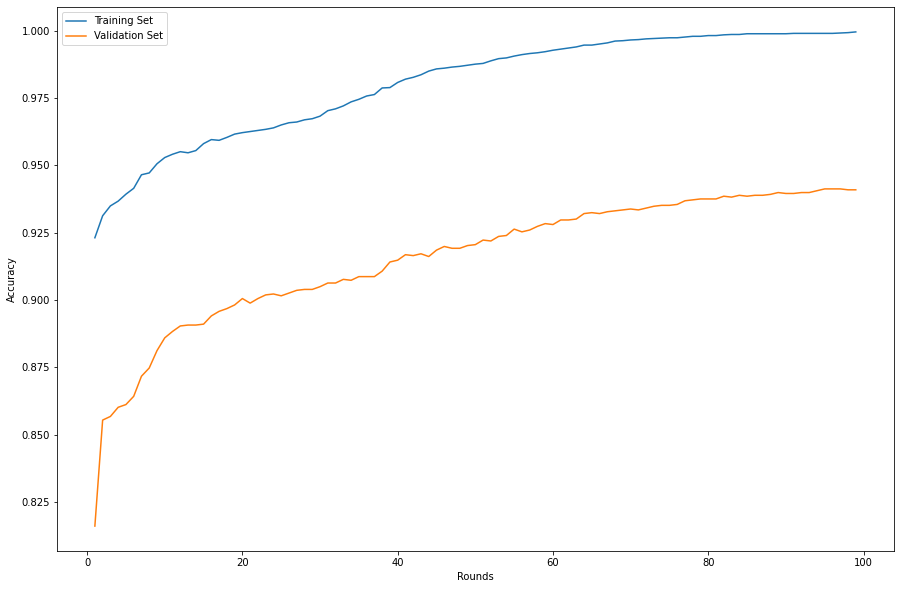

In [30]:
# Plot the training and validation set performance over time
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(rounds, train_performance, label="Training Set")
plt.plot(rounds, val_performance, label="Validation Set")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.ax = ax
plt.legend()

## Feature Importance

XGBoots provide function to plot feature importance and it can help to identify which features are the most important for the model. If a feature has a high importance, it means that it contributes more to the model's predictions. If the feature importance of some features is too high, it may indicate overfitting because the model is too dependent on them.

based on the plot result, we can not say any feature has significant larger than others

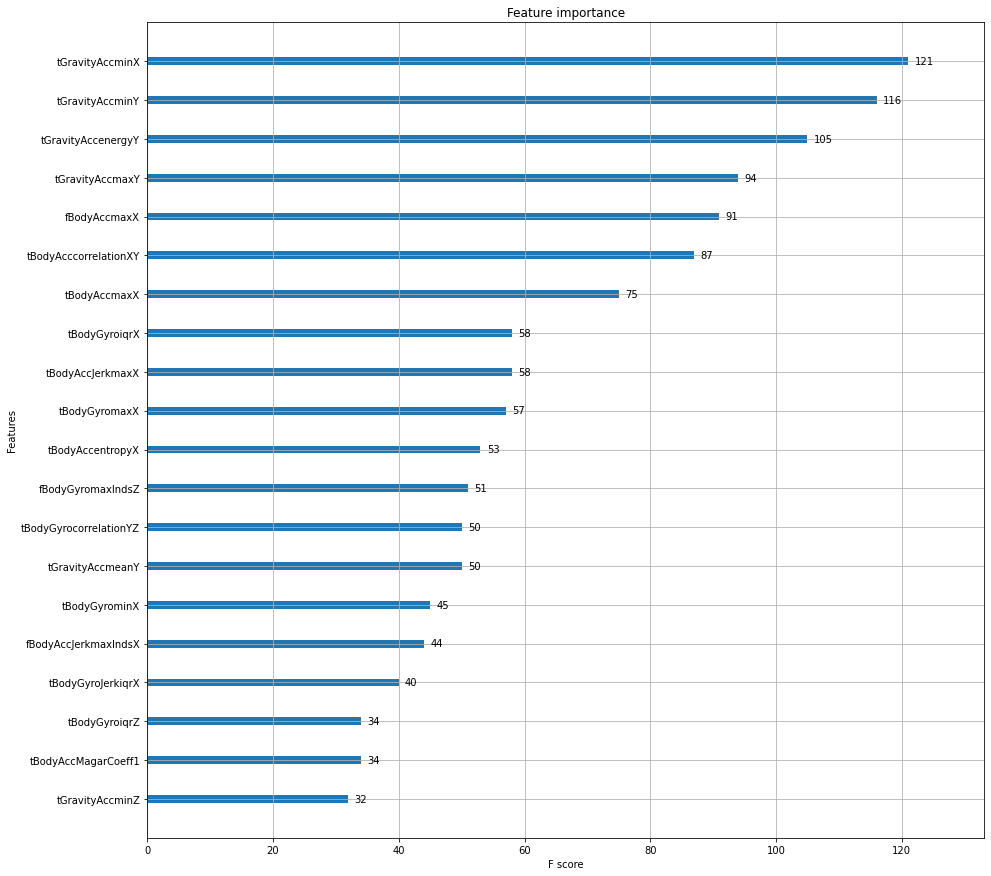

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
xgb.plot_importance(model, ax=ax, max_num_features=20)

# Experiment Result

## confusion matrix

In the work XGBoosts, given us 94.13% acccuracy in test set.

Based on the Confusion matrix most of the classes are correct.

Except "Standing" and "sitting", which we can do more analysis in future work.

In [27]:
y_pred = model.predict(X_val)
accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred)
print(accuracy)

0.9412962334577536


Text(113.09375, 0.5, 'True')

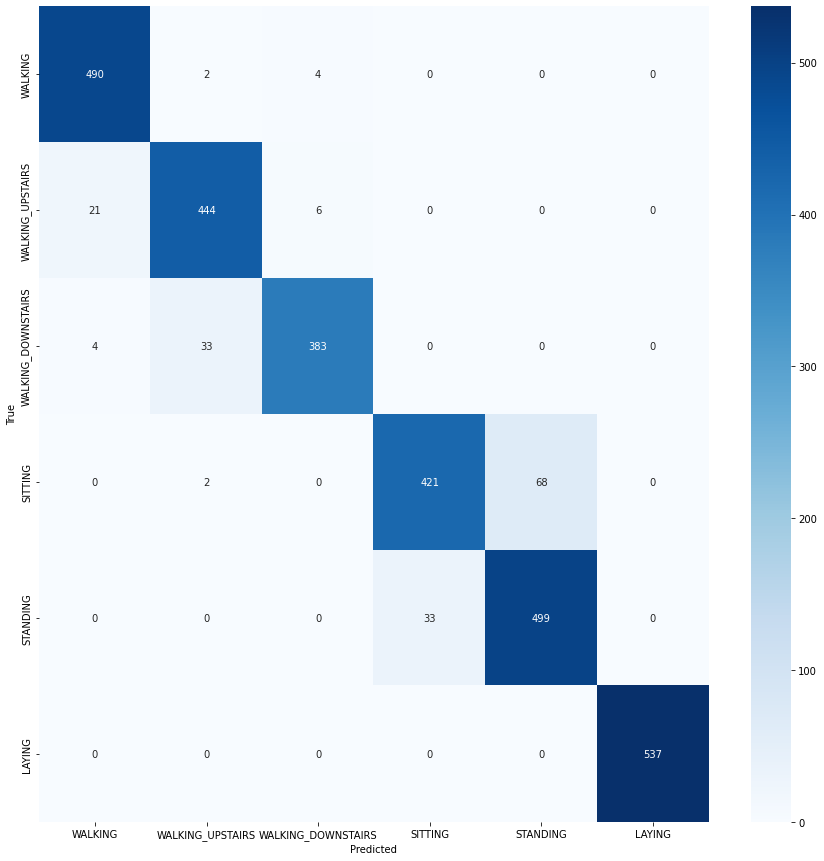

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))
# make predictions on the test set
y_pred = model.predict(X_val)

# create the confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=labels)

# plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')

# Conclusion

Here are some pros and cons of using XGBoost for multi-class classification:

Pros:

- XGBoost is a highly efficient and scalable algorithm that can handle large datasets with millions of examples and features.
It can handle missing values and categorical variables, which can be transformed into numerical values using one-hot encoding.
- XGBoost uses a technique called "boosting" which combines the predictions of multiple weak models to produce a strong final prediction. This makes the model robust to overfitting and improves its generalization performance.
- XGBoost provides several regularization options such as L1 and L2 regularization which can help prevent overfitting.
It has built-in support for parallel processing which can speed up the training process.
- XGBoost has a built-in feature importance analysis mechanism, which allows you to understand which features are most important in determining the output of the model.
- XGBoost can handle imbalanced datasets where some classes have much fewer examples than others


Cons:

- XGBoost requires careful tuning of its many hyperparameters, such as the learning rate, number of trees, and regularization parameters. This can be time-consuming and requires a good understanding of the algorithm.
- XGBoost can be sensitive to the initial conditions of the data, and in some cases, it may not converge or produce poor results if the data is not properly preprocessed.
- It can be memory-intensive and may require a powerful machine to handle large datasets.
- The interpretability of the model can be difficult as it's a complex ensemble of decision trees.
- It may take longer time to train a model than other algorithms such as Random Forest or Logistic Regression.

# Additional

## Regularization and tuning by GridSearchCV

We can use Grid Search CV to tuning the parameters of model. for example, tunning the regulariztion rate.

It takes too long to run thus here is the sample code,

In [ ]:
model = xgb.XGBClassifier(reg_lambda=0.1, early_stopping_rounds=10, eval_set=[(X_val, y_val)])

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'reg_lambda':[0.01, 0.001]}#[0, 0.001, 0.01, 0.1, 1, 10, 100]}
clf = RandomizedSearchCV(model, param_grid, cv=5)

In [ ]:
# Fit the model to the training data
clf.fit(X_train, y_train, eval_metric="merror")

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(early_stopping_rounds=10,
                                           eval_set=[(      tBodyAccmeanX  tBodyAccmeanY  tBodyAccmeanZ  tBodyAccstdX  tBodyAccstdY  \
0              0.26          -0.02          -0.01         -0.94         -0.92   
1              0.29          -0.01          -0.12         -0.98         -0.97   
2              0.28          -0.03          -0.12         -0.99         -0.97   
3              0.27          -0.03          -0.12         -0.99         -0.97   
4              0.27          -0.03          -0.13         -0.99         -0.97   
...             ...            ...            ...           ...           ...   
2942           0.31          -0.05          -0.10         -0.29         -0.14   
2943           0.36          -0.04          -0.11         -0.31          0.03   
2944...
2942              -0.65               0.27               0.18  
2943              -0.66               0.27         

In [131]:
# Make predictions on the training and validation sets
train_predictions = clf.predict(X_train)

In [132]:

val_predictions = clf.predict(X_val)

In [133]:
# Evaluate the model's accuracy on the training and validation sets
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

In [134]:
print(f'{train_accuracy=}, {val_accuracy=}')

train_accuracy=0.999455930359086, val_accuracy=0.9399389209365456
